In [1]:
import __casac__ as cc
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits as pf
from dsacalib.utils import *
from dsacalib.calib import * 
from dsacalib.plotting import *
%matplotlib inline

/home/simard/anaconda3/envs/casa/lib/python3.6/site-packages/matplotlib/__init__.py:576: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.6 or later is installed on your system
  'your system' % dvipng_req)


In [2]:
# Define the file, source and pointing parameters
datadir= 'data'
fl     = '{0}/J1459+7140/flagged.fits'.format(datadir) 
cal    = src('J1459+7140',7.47,'14h59m07.63s','+71d40m19.9s')
sr0    = src('J1520+7225',1.5491,'15h20m47.46s','+72d25m04.80s')
antenna_order = [8,5,7,4,3,0,9,1,6,2]

## Find calibration solutions using calibrator

In [3]:
# Open the file and get info from the header and visibilities
fo = pf.open(fl,ignore_missing_end=True)
f  = fo[1]
nchan, fobs, nt, blen, bname, tstart, tstop = \
    get_header_info(f,verbose=True)
vis,lst,mjd,transit_idx = extractVis(f,cal.ra.to_value(u.rad),
                                  (25*u.min*(15*u.deg/u.h)).
                                     to_value(u.rad),'A')
fo.close()
# Reorder the visibilities to fit with CASA ms convention
vis = vis[::-1,...]
bname = bname[::-1]
blen = blen[::-1,...]

File covers 1.01 h hours from MJD 58753.9250881348 to 58753.967096419525


In [4]:
vis = vis/visibility_model(blen,[cal],mjd,fobs)

#### Write 10-s fringe-stopped visibilities to ms

In [5]:
convert_to_ms(cal,vis,mjd[0],'{0}.ms'.format(cal.name),bname)

#### Delay calibration

In [6]:
delay_calibration('{0}'.format(cal.name),prefix=cal.name)

#### Use deviations from average delay calibration to flag bad times

In [7]:
cb = cc.calibrater.calibrater()
cb.open('{0}.ms'.format(cal.name))
cb.setsolve(type='K',t='59s',
        refant=0,table='{0}2kcal'.format(cal.name))
cb.solve()
cb.close()

True

In [8]:
cb = cc.calibrater.calibrater()
cb.open('{0}.ms'.format(cal.name))
cb.setsolve(type='K',t='59s',
        refant=0,table='{0}2kcal'.format(cal.name))
cb.solve()
cb.close()

True

In [9]:
tb = cc.table.table()
tb.open('{0}2kcal'.format(cal.name))
antenna_delays = tb.getcol('FPARAM')[0][0].reshape(-1,10)
times = tb.getcol('TIME').reshape(-1,10)[:,0]
tb.close()

True

In [10]:
tb = cc.table.table()
tb.open('{0}kcal'.format(cal.name))
kcorr = tb.getcol('FPARAM')[0][0]
tb.close()

True

/home/simard/anaconda3/envs/casa/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


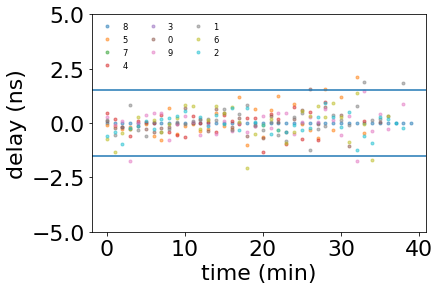

In [11]:
for i in range(10):
    plt.plot(antenna_delays[:,i]-kcorr[i],'.',
            label=antenna_order[i],alpha=0.5)
plt.ylim(-5,5)
plt.ylabel('delay (ns)')
plt.legend(ncol=3,fontsize='small')
plt.xlabel('time (min)')
plt.axhline(1.5)
plt.axhline(-1.5)

In [12]:
bad_times = (np.abs(antenna_delays-kcorr)>1.5)
bad_times[np.sum(bad_times,axis=1)>3,:]=np.ones(bad_times.shape[1])
flag_badtimes('{0}'.format(cal.name),times,bad_times)

#### Flag antennas that we know are bad and short baselines with crosstalk

In [13]:
flag_antenna('{0}'.format(cal.name),4)
flag_antenna('{0}'.format(cal.name),2)
flag_antenna('{0}'.format(cal.name),"3,5,7,9&")

#### Gain calibration

In [14]:
# Solve for phase calibration over entire obs
cb = cc.calibrater.calibrater()
cb.open('{0}.ms'.format(cal.name))
cb.setapply(type='K',table='{0}kcal'.format(cal.name))
cb.setsolve(type='G',table='{0}gpcal'.format(cal.name),t='inf',
                 minblperant=1,refant='0',apmode='p')
cb.solve()
cb.close()

# Solve for gain calibration on 10 minute timescale
cb = cc.calibrater.calibrater()
cb.open('{0}.ms'.format(cal.name))
cb.setapply(type='K',table='{0}kcal'.format(cal.name))
cb.setapply(type='G',table='{0}gpcal'.format(cal.name))
cb.setsolve(type='G',table='{0}gacal'.format(cal.name),t='600s',
                 minblperant=1,refant='0',apmode='a')
cb.solve()
cb.close()

# Apply calibration
cb = cc.calibrater.calibrater()
cb.open('{0}.ms'.format(cal.name))
cb.setapply(type='K',table='{0}kcal'.format(cal.name))
cb.setapply(type='G',table='{0}gpcal'.format(cal.name))
cb.setapply(type='G',table='{0}gacal'.format(cal.name))
cb.correct()
cb.close()

True

#### Look at solutions

In [15]:
tb = cc.table.table()
tb.open('{0}gpcal'.format(cal.name))
gain_phase = tb.getcol('CPARAM')[0,...]
gain_phase = gain_phase.reshape(-1,10)
tb.close()

tb = cc.table.table()
tb.open('{0}gacal'.format(cal.name))
gain_amp = tb.getcol('CPARAM')[0,...]
gain_amp = gain_amp.reshape(-1,10)
tb.close()

True

Text(0,0.5,'Phase of gain')

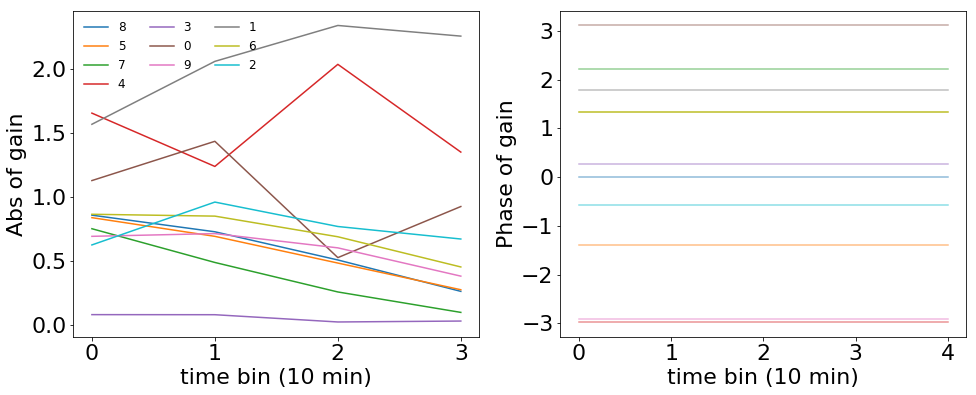

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
for i in range(10):
    ax[0].plot(np.abs(gain_amp[:,i]),label=antenna_order[i])
    ax[1].plot([0,gain_amp.shape[0]],[np.angle(gain_phase[:,i]),
              np.angle(gain_phase[:,i])],alpha=1 if antenna_order[i]==6 else 0.5)
ax[0].legend(ncol=3,fontsize=12)
ax[0].set_xlabel('time bin (10 min)')
ax[1].set_xlabel('time bin (10 min)')
ax[0].set_ylabel('Abs of gain')
ax[1].set_ylabel('Phase of gain')

Image shape: [256 256   1   1]
Peak SNR at pix (147,0) = 5.993289336935007
Value at peak: 1.4889639616012573
Value at origin: 1.1122069358825684
1 errors occured during imaging


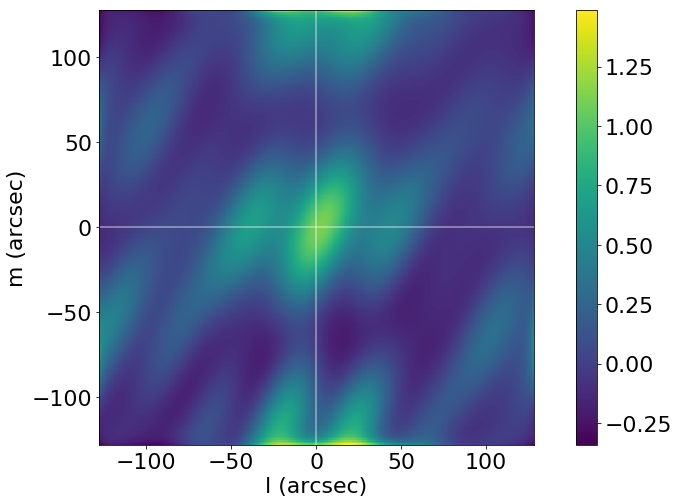

In [17]:
plot_image('{0}'.format(cal.name),'corrected',cal,verbose=True)

## Apply solution to target source

In [18]:
fo = pf.open(fl,ignore_missing_end=True)
f  = fo[1]
vis,lst,mjd,transit_idx = extractVis(f,sr0.ra.to_value(u.rad),
                                  (5*u.min*(15*u.deg/u.h)).
                                     to_value(u.rad),'A')
fo.close()
# Reorder the visibilities to fit with CASA ms convention
vis = vis[::-1,...]

In [19]:
vis = vis/visibility_model(blen,[sr0],mjd,fobs,phase_only=True)

In [20]:
convert_to_ms(sr0,vis,mjd[0],'{0}.ms'.format(sr0.name),bname)

#### Flag bad antennas and short baselines

In [21]:
flag_antenna('{0}'.format(sr0.name),4)
flag_antenna('{0}'.format(sr0.name),2)
flag_antenna('{0}'.format(sr0.name),"3,5,7,9&")

#### Calibrate

In [22]:
cb = cc.calibrater.calibrater()
cb.open('{0}.ms'.format(sr0.name))
cb.setapply(type='K',table='{0}kcal'.format(cal.name))
cb.setapply(type='G',table='{0}gacal'.format(cal.name))
cb.setapply(type='G',table='{0}gpcal'.format(cal.name))
cb.correct()
cb.close()

True

#### Look at calibrated data

In [23]:
ms = cc.ms.ms()
ms.open('{0}.ms'.format(sr0.name))
data = ms.getdata(['corrected_data'])
vis_cal = data['corrected_data'][0,...].reshape(625,-1,45).T
ms.close()
mjd = np.mean(mjd[:25])+np.arange(vis_cal.shape[1])*np.median(np.diff(mjd))*25

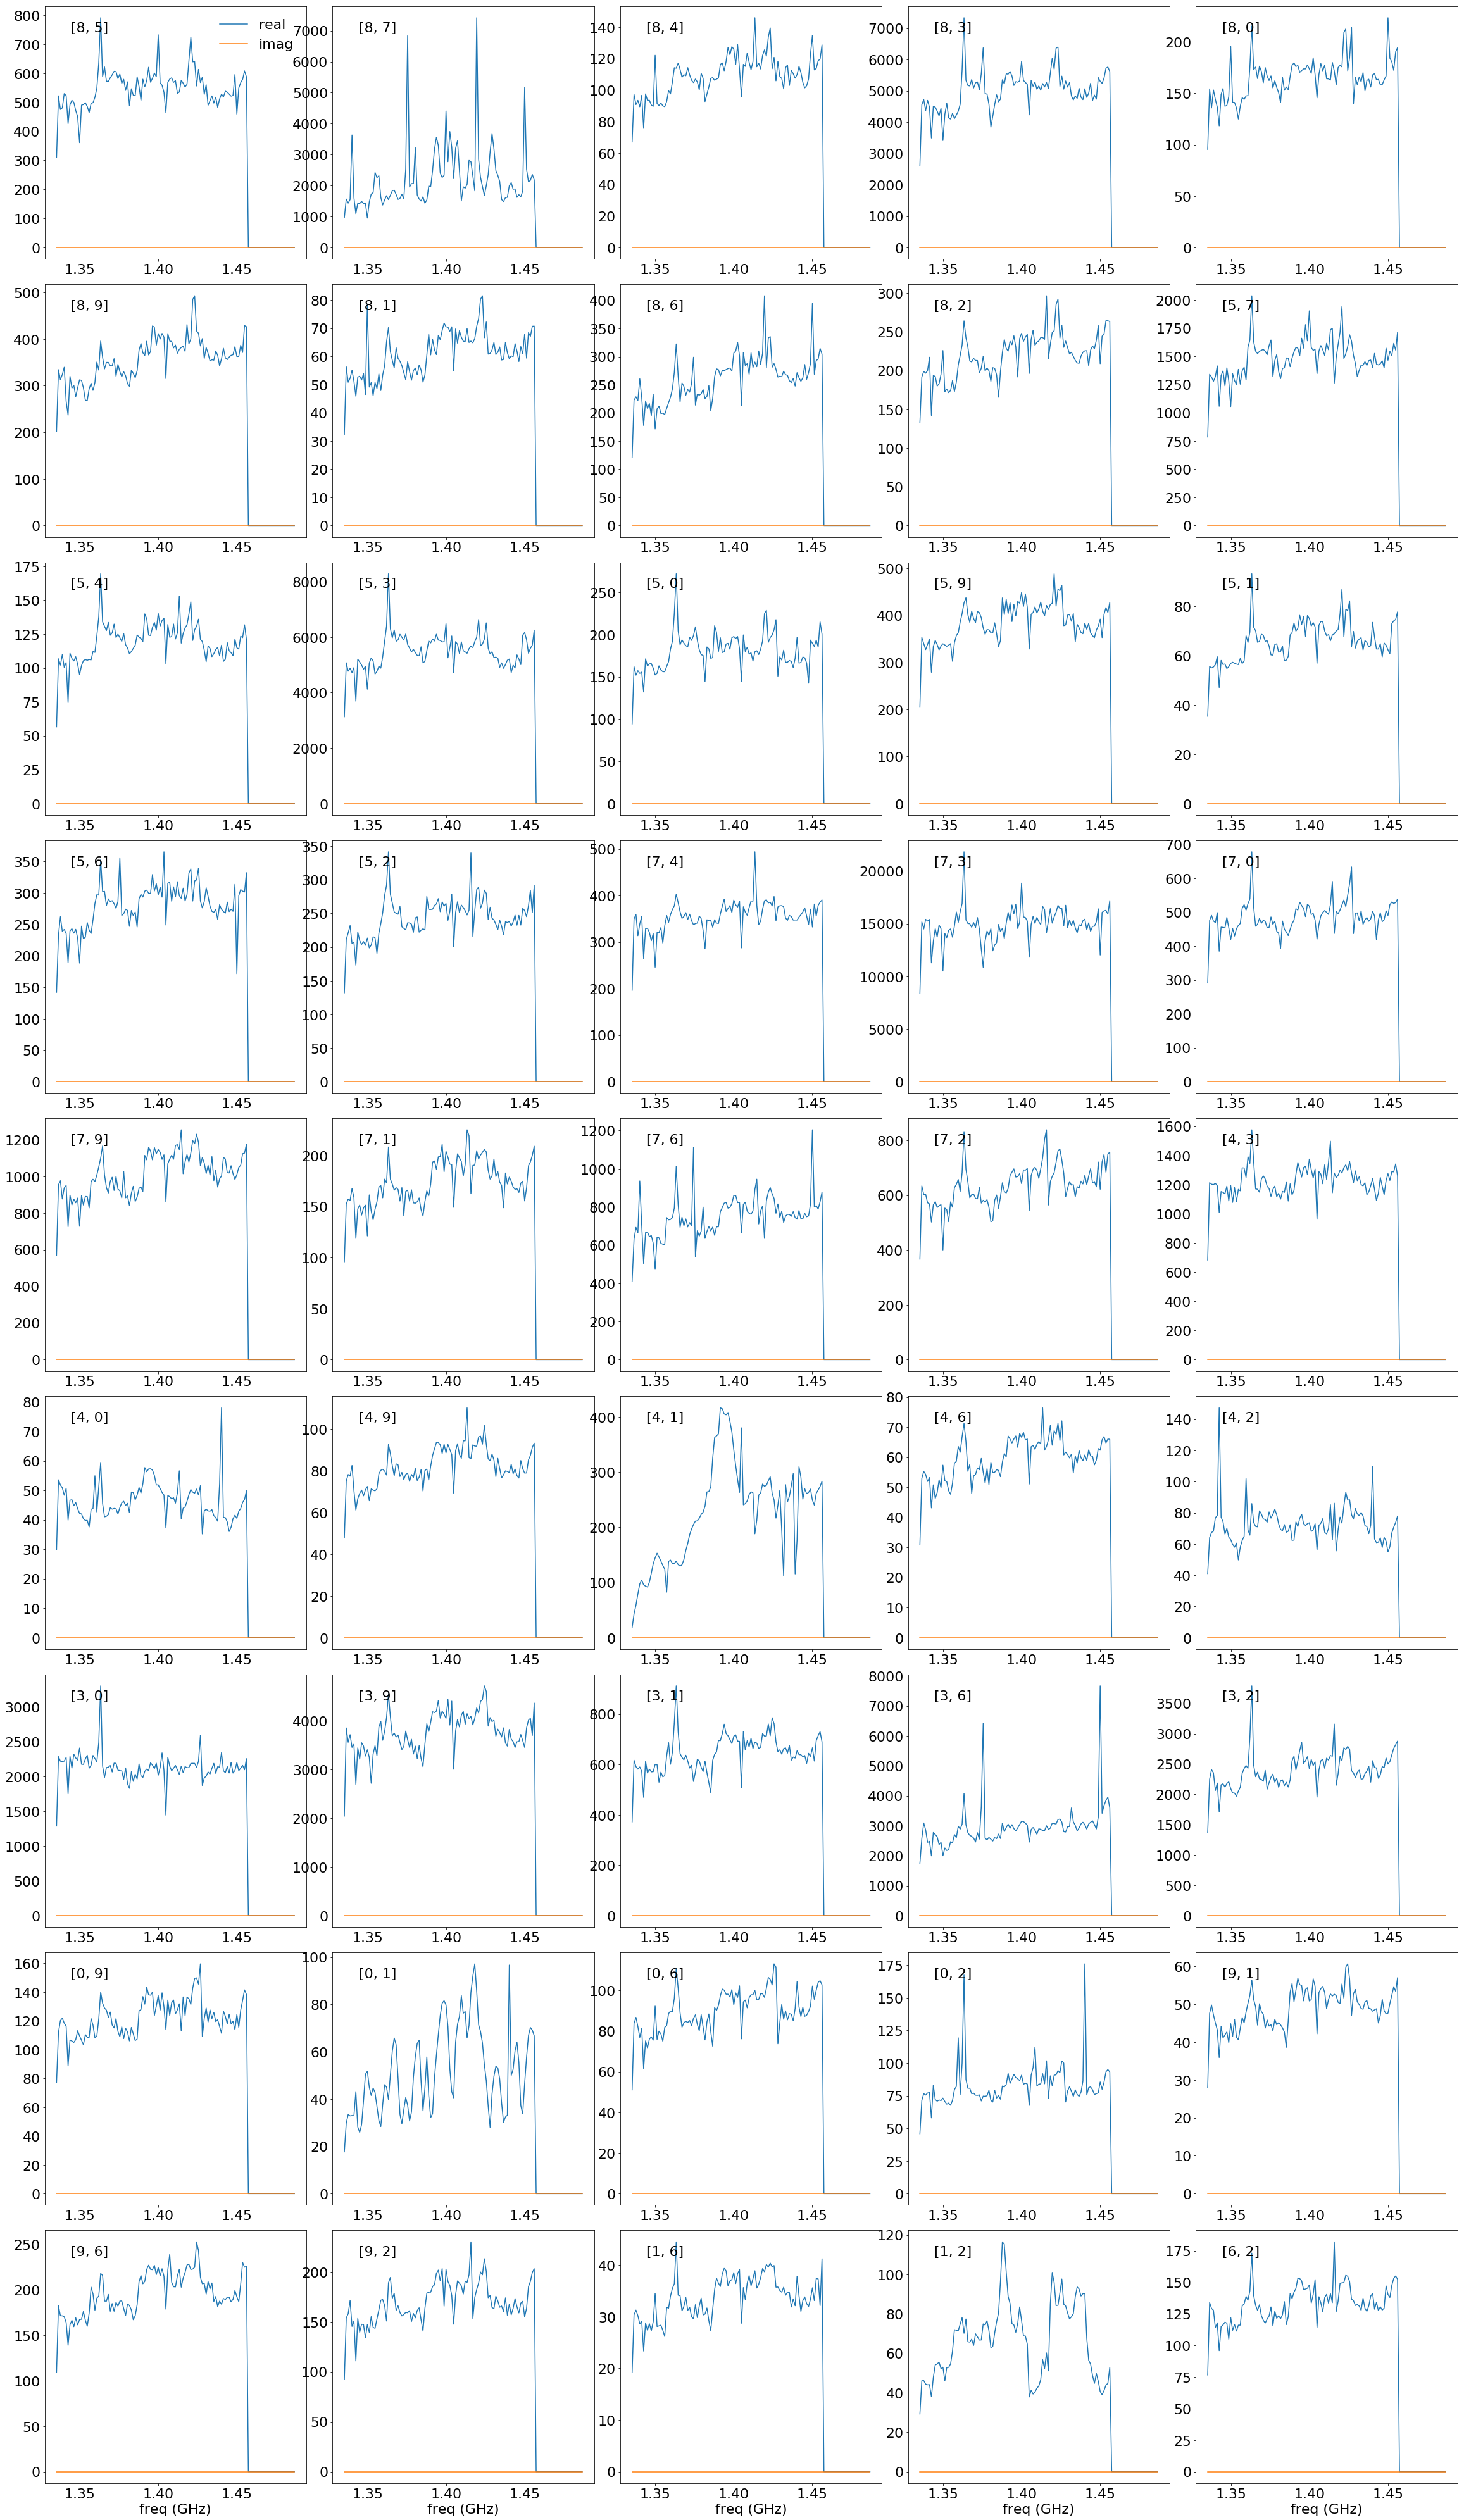

In [24]:
plot_vis_freq(np.abs(vis_cal),fobs,bname)

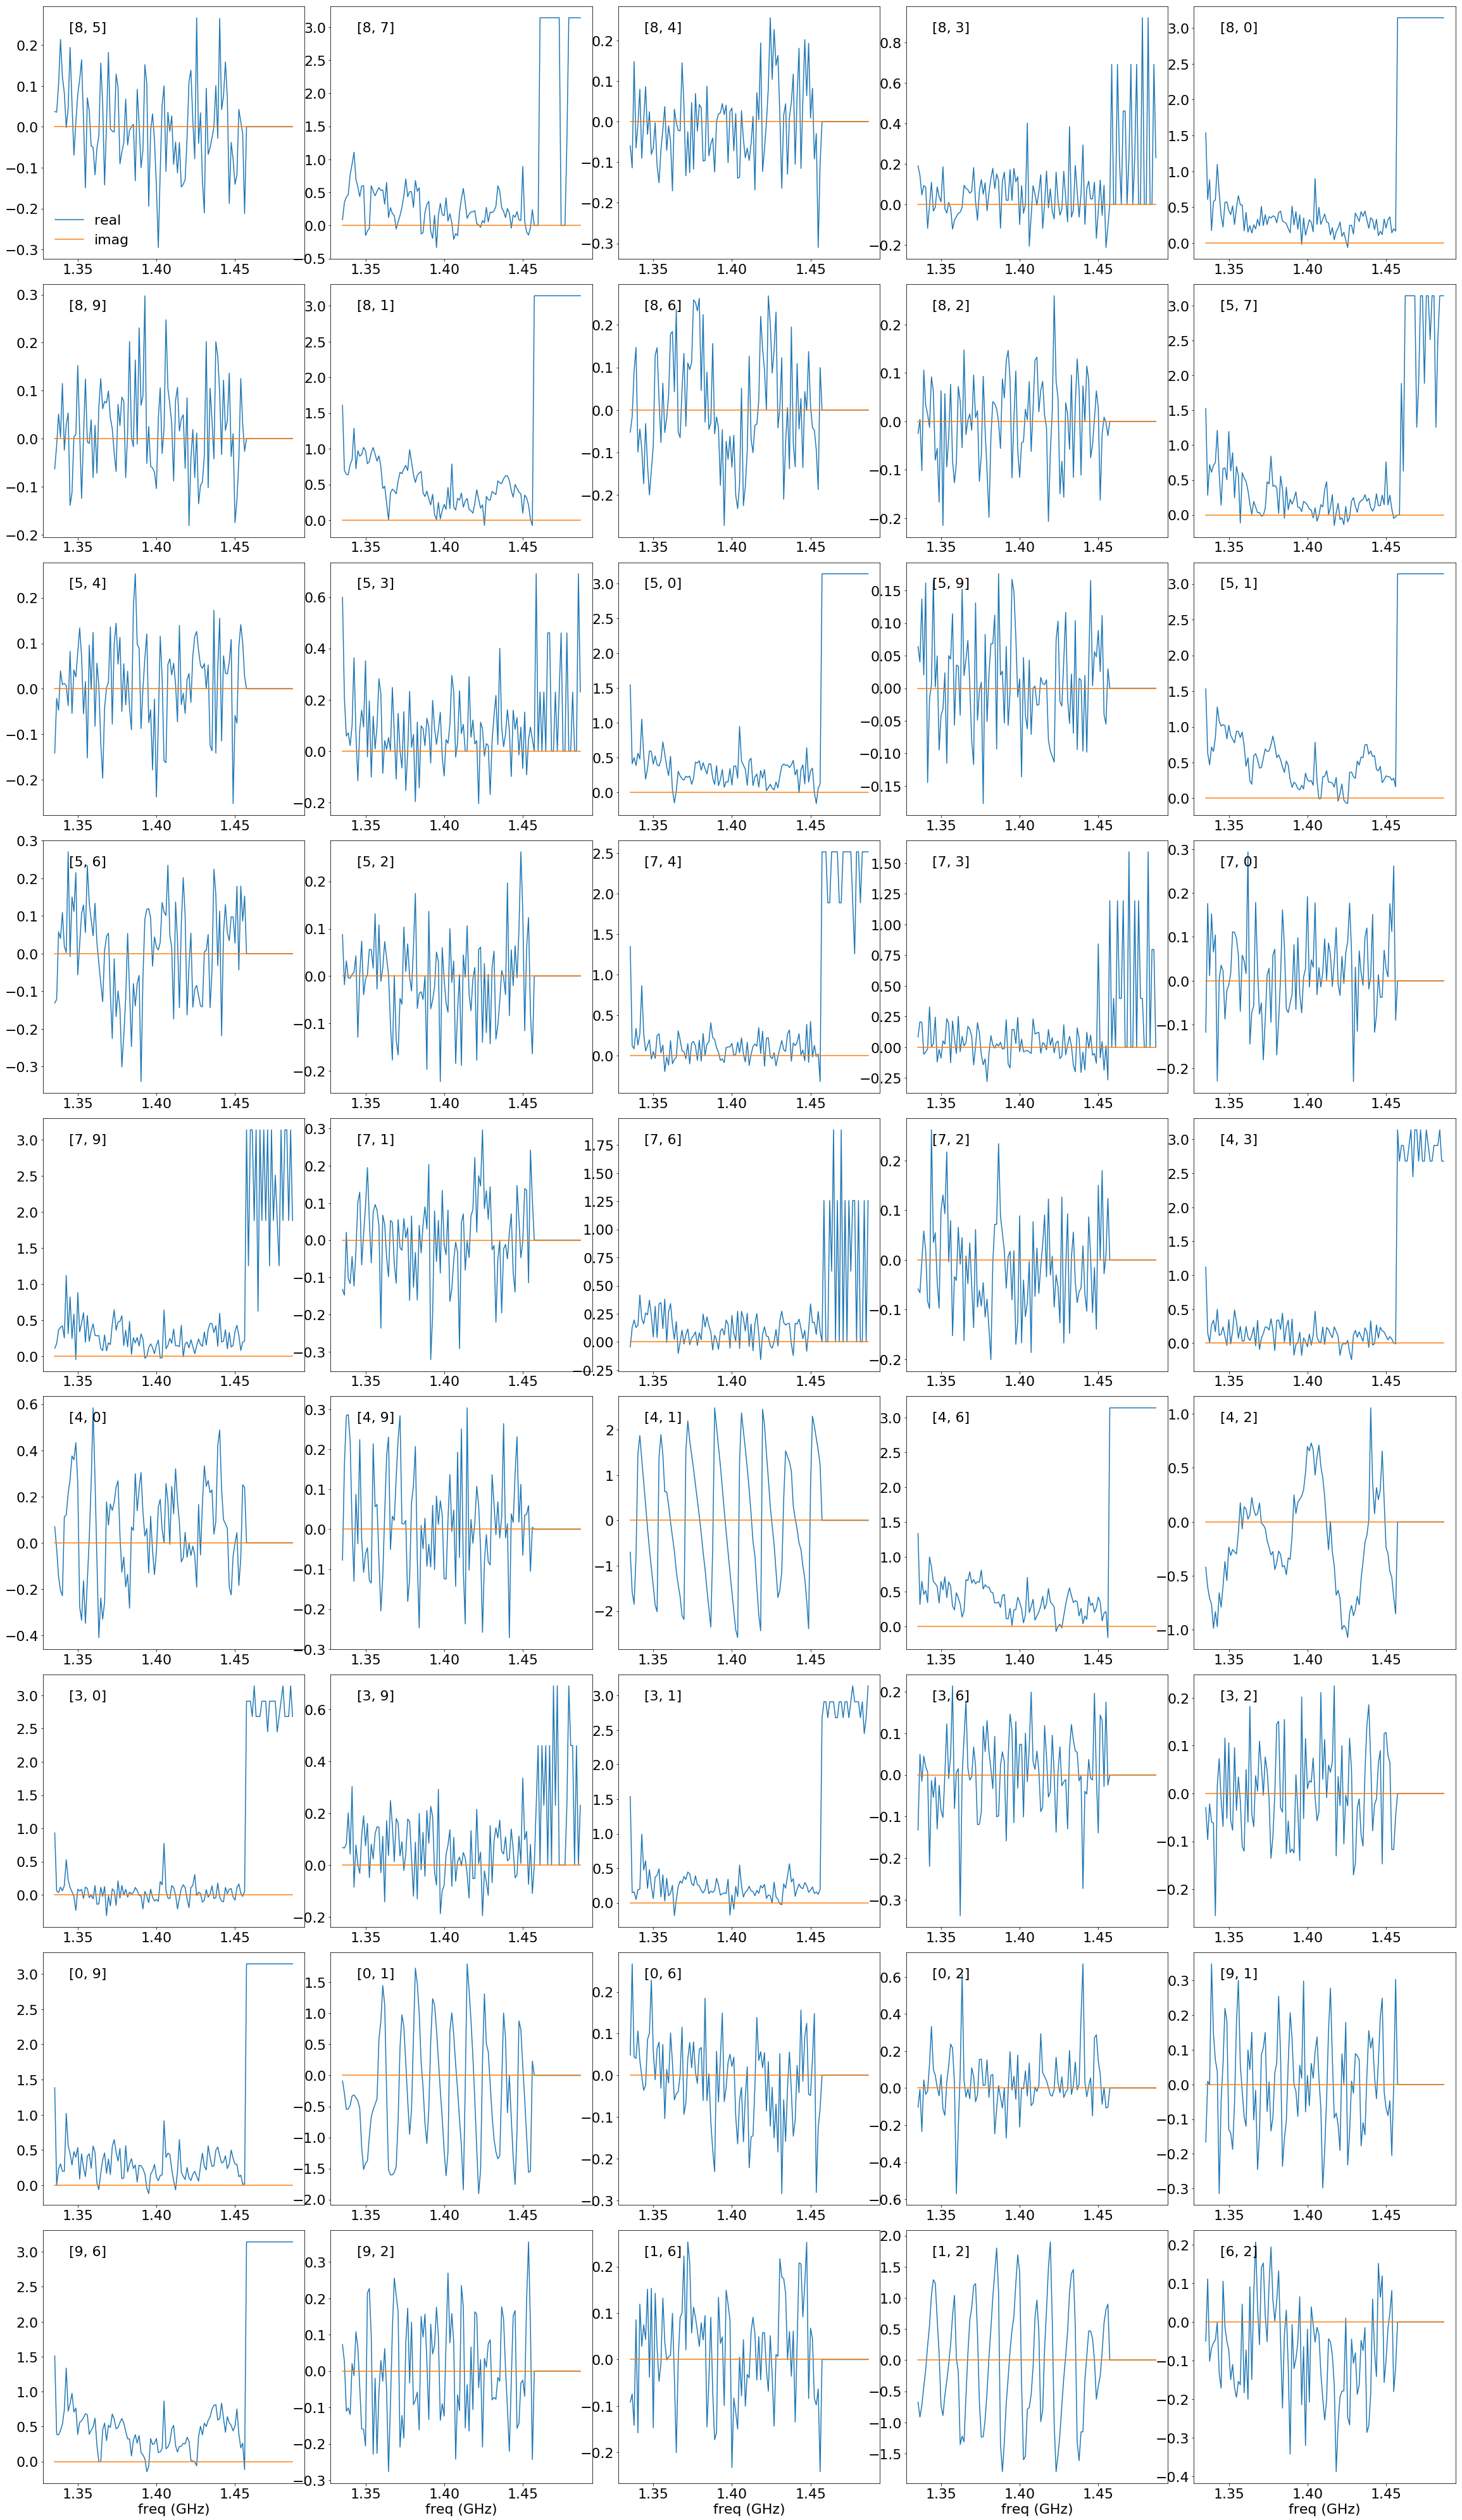

In [25]:
plot_vis_freq(np.angle(vis_cal),fobs,bname)

In [31]:
plot_vis_time(np.abs(vis_cal),mjd,bname)

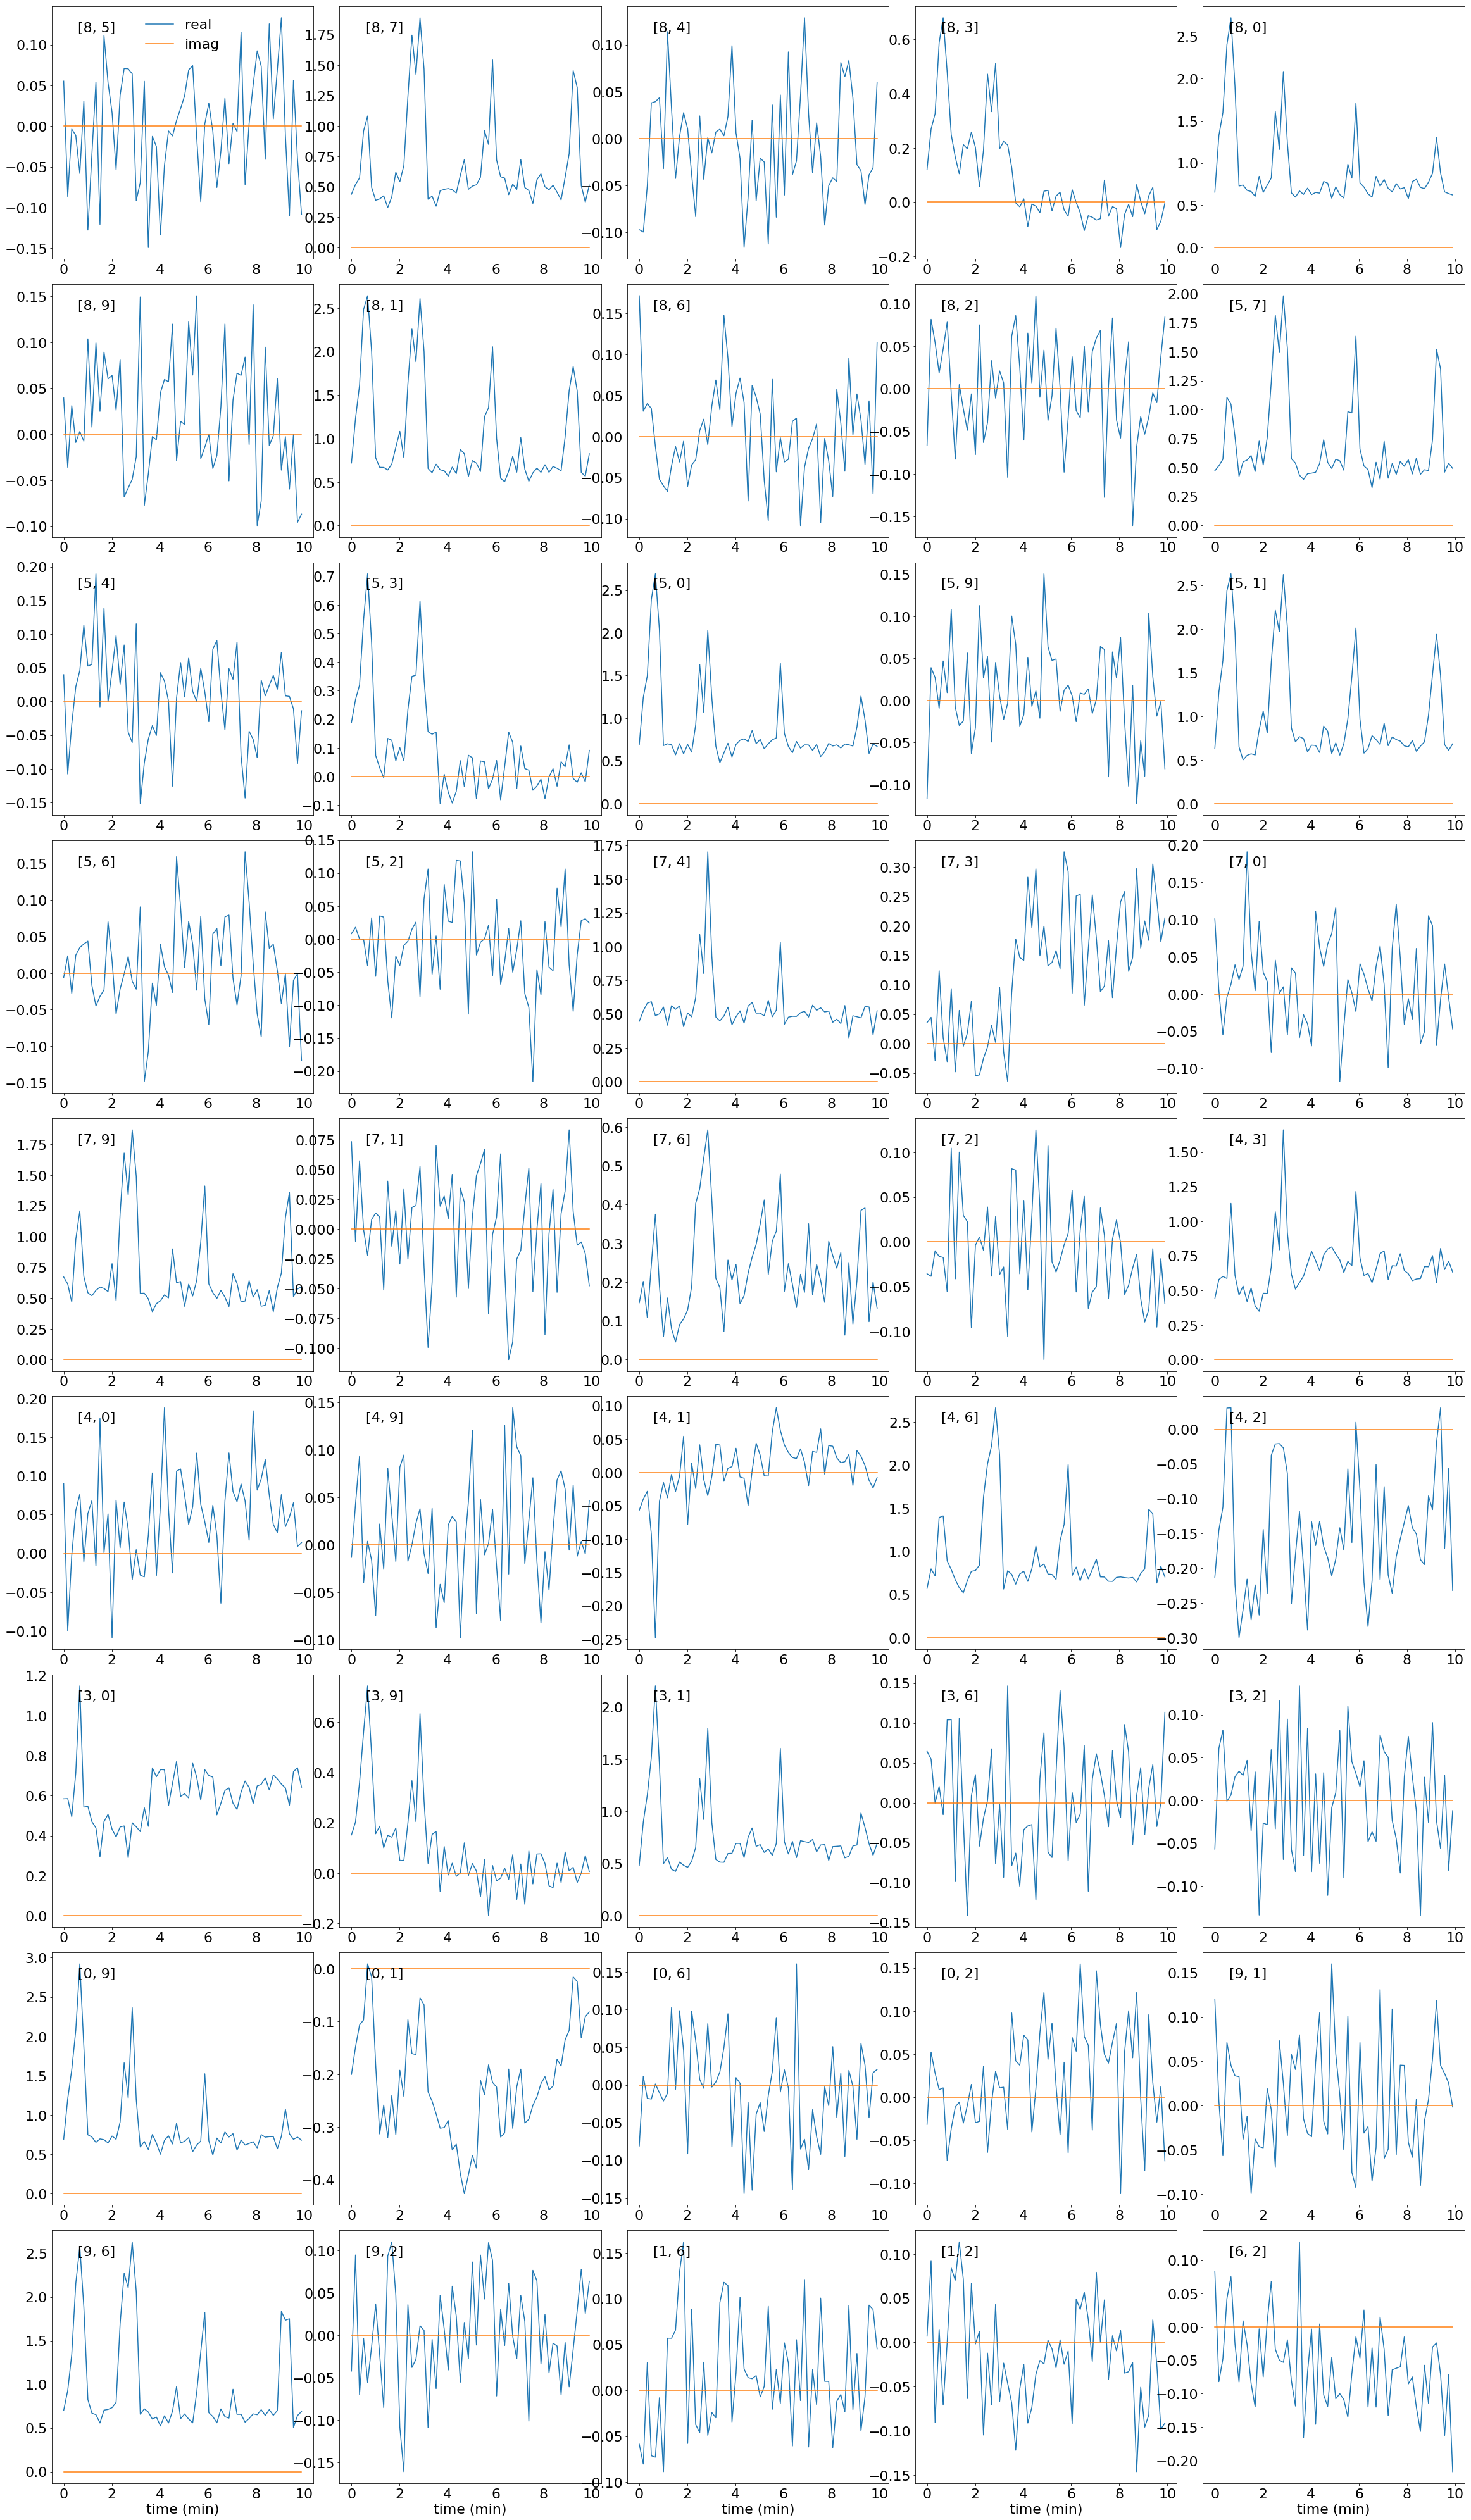

In [28]:
plot_vis_time(np.angle(vis_cal),mjd,bname)

Image shape: [128 128   1   1]
Peak SNR at pix (64,65) = 3.321771911145198
Value at peak: 14.900532722473145
Value at origin: 14.890375137329102
1 errors occured during imaging


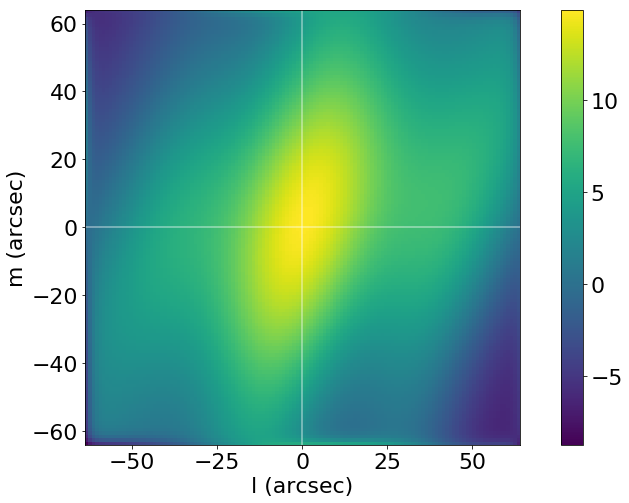

In [29]:
plot_image('{0}'.format(sr0.name),'corrected',sr0,verbose=True,
          npix=128)

Image shape: [256 256   1   1]
Peak SNR at pix (128,129) = 3.6234004439022973
Value at peak: 14.901643753051758
Value at origin: 14.89076042175293
1 errors occured during imaging


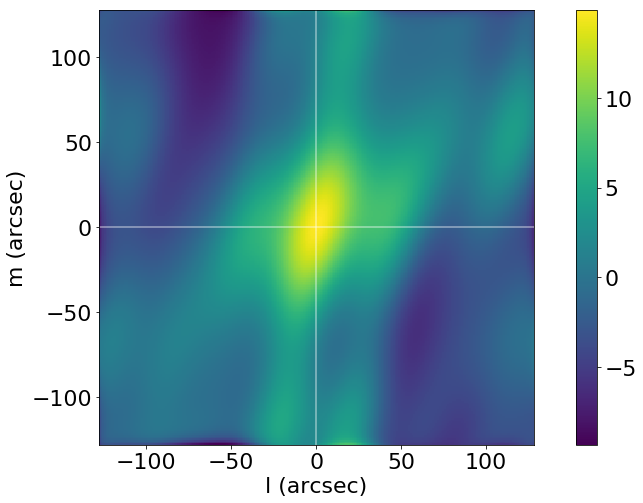

In [30]:
plot_image('{0}'.format(sr0.name),'corrected',sr0,verbose=True)